In [586]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import operator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim.corpora.dictionary import Dictionary
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
wnl = WordNetLemmatizer()

In [587]:
df = pd.read_excel(r'C:\Users\Yunseok Choi\Google 드라이브\기술경영대학원\STEPI\AI_Healthcare_PUB_country.xlsx', index_col = 0)
df.drop('Unnamed: 0.1', axis = 1, inplace = True )
df.fillna('', inplace = True)

In [588]:
stword = stopwords.words('english')
#Stopword 추가
stword_add = ['one','two','three','four','five','six','seven','eight','nine','ten', 'increasing','decreasing',
              'half','must','say','said','able','therefore','higher','lower','better','asking','largerst','smallest','come',
             'th','highest','lowest','whatever','help','v','c','high','low','iii','i','ii','iv','v','vi','vii','viii','every',
             'first','second','third','fourth','fifth','sixth','seventh','eighth', 'also', 'table', 'fig']
stword.extend(stword_add)
stword.extend(['de','however','use','used','de'])
stword.extend(['big','small'])

In [589]:
def text_extraction(min_year = 2000,max_year = 2020,country_name = '', data = df):
    i = 0
    cps_name, cps_data = [], []
    if country_name == '':
        for item in df[(df['Publication Year'] <= max_year) & (df['Publication Year'] >= min_year)]['Abstract']:
            globals()['cps{}'.format(i)] = item.lower()
            cps_name.append('cps{}'.format(i))
            cps_data.append(globals()['cps{}'.format(i)])
            i += 1
    if country_name != '':
        for item in df[(df['Publication Year'] <= max_year) & (df['Publication Year'] >= min_year) & (df['Country'] == country_name)]['Abstract']:
            globals()['cps{}'.format(i)] = item.lower()
            cps_name.append('cps{}'.format(i))
            cps_data.append(globals()['cps{}'.format(i)])
            i += 1
    return cps_name, cps_data

In [590]:
#Defining functino for plotting with word frequency limitation as input.
def coherence_score(limit, passes = 15, cps_data = cps_data):
    tokenizer = RegexpTokenizer('\w+')
    p_stemmer = PorterStemmer()
    texts = []
    for item in cps_data:
        #corpus 속 숫자 제거
        temp = re.sub('[0-9]+','',item)
        tokens = tokenizer.tokenize(temp)
        #1글자로 이루어진 단어 제거
        tokens_overone = [word for word in tokens if len(word) > 1]
        #stopword 제거
        stopped_tokens = [i for i in tokens_overone if not i in stword]    
        # ing형 제거
        noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
        # ly형 제거
        nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
        #각 단어 표제화
        lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
        texts.append(lemmatized_words)

    frequency = {}
    for corpus in texts:
        for word in corpus:
            if word in frequency.keys():
                frequency[word] +=1
            else:
                frequency[word] = 1
    texts_filtered = [ [token for token in text if (1 < frequency[token] < limit) ] for text in texts ]

    #표제화된 단어들을 이용하여 document-term 테이블 생성
    dictionary = Dictionary(texts_filtered)
    docfreq = dictionary.dfs
    doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

    #토픽의 개수별 gensim LDA 모델의 coherence score 체크
    coherence_values = []
    model_list = []
    for n_topics in range(2,30,1):
        model = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = n_topics, id2word = dictionary, 
                                         passes=passes, alpha = 'symmetric', iterations = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    x = range(2,30,1)
    plt.plot(x, coherence_values)
    plt.title('Coherence Score of LDA (< {} Counts)'.format(limit))
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'),loc = 'best')
    return plt.show()

In [591]:
#defining print function of showing 15 keywords and document-topic information, 
#having word frequency limit and number of topics as input.
def lda_analysis(limit, num_tps):
    
    frequency = {}
    for corpus in texts:
        for word in corpus:
            if word in frequency.keys():
                frequency[word] +=1
            else:
                frequency[word] = 1
    texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

    #표제화된 단어들을 이용하여 document-term 테이블 생성
    dictionary = Dictionary(texts_filtered)
    docfreq = dictionary.dfs
    doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

    ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                        passes=15, alpha = 'symmetric', iterations = 10)
    ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
    temp = []
    for i in range(len(ldaTopics)):
        string = ''
        for item in ldaTopics[i][1].split('+'):
            string += (item.split('*')[1].replace(r'"','') + '')
        temp.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
    print(temp)
    for i in range(len(doc_term_matrix)):
        print(ldaModel[doc_term_matrix[i]])

## 2010~2020, 전체 데이터

In [592]:
cps_name, cps_data = text_extraction(2010,2020)

In [593]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

12662


Text(0, 0.5, 'Frequency')

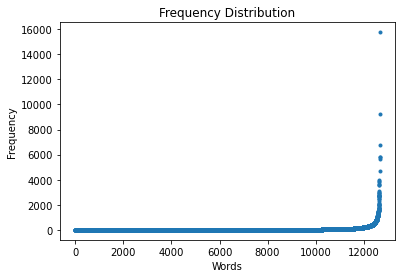

In [303]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [304]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

data 15749
healthcare 9257
patient 6780
system 5842
model 5839
health 5681
based 4696
method 4004
big 3867
machine 3816
study 3621
medical 3587
result 3557
used 3062
paper 3019
disease 2980
network 2931
information 2875
application 2821
algorithm 2731
approach 2730
analysis 2717
proposed 2700
time 2699
care 2686
research 2679
technology 2564
ai 2484
clinical 2453
use 2274


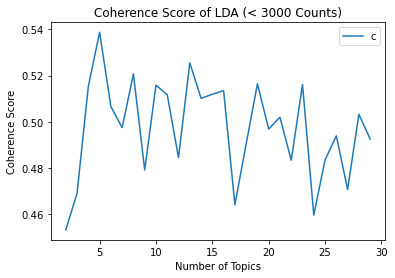

In [309]:
coherence_score(3000)

In [594]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 3000
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [598]:
keywords

[['Topic 0',
  'ai, care, research, clinical, medicine, practice, intelligence, review, artificial, development, technology, potential, student, challenge, need'],
 ['Topic 1',
  'network, proposed, deep, neural, time, image, feature, sensor, accuracy, algorithm, activity, classification, approach, application, signal'],
 ['Topic 2',
  'disease, risk, hospital, prediction, cost, care, clinical, factor, outcome, year, treatment, diabetes, predictive, variable, rate'],
 ['Topic 3',
  'technology, information, application, service, analytics, cloud, iot, challenge, analysis, smart, privacy, security, framework, user, new'],
 ['Topic 4',
  'algorithm, decision, approach, performance, classification, feature, technique, support, information, prediction, cancer, accuracy, classifier, ml, dataset']]

In [476]:
df_filtered = df[(df['Publication Year'] <= 2020) & (df['Publication Year'] >= 2010)]
df_filtered.reset_index(inplace = True)

In [477]:
usa_index = df_filtered[df_filtered['Country'] == 'USA'].index

In [597]:
topic_ratio_all = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in range(0,df_filtered.shape[0],1):
    for item in topic_ratio[index]:
        topic_ratio_all[item[0]] += item[1]
for index in topic_ratio_all.keys():
    topic_ratio_all[index] = topic_ratio_all[index]/df_filtered.shape[0]
topic_ratio_all

{0: 0.20768035036332297,
 1: 0.23451814426422862,
 2: 0.162762827569411,
 3: 0.26721057507993007,
 4: 0.12261596776958754,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [395]:
topic_ratio_usa = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in usa_index:
    for item in topic_ratio[index]:
        topic_ratio_usa[item[0]] += item[1]
for index in topic_ratio_usa.keys():
    topic_ratio_usa[index] = topic_ratio_usa[index]/len(usa_index)
topic_ratio_usa

{0: 0.19199494514899706,
 1: 0.2559575335126536,
 2: 0.12974060650442762,
 3: 0.1287771977178109,
 4: 0.2887625373759849,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [478]:
china_index = df_filtered[df_filtered['Country'] == 'China'].index

In [397]:
topic_ratio_china = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in china_index:
    for item in topic_ratio[index]:
        topic_ratio_china[item[0]] += item[1]
for index in topic_ratio_china.keys():
    topic_ratio_china[index] = topic_ratio_china[index]/len(china_index)
topic_ratio_china

{0: 0.3202295124365558,
 1: 0.12578041366143752,
 2: 0.2782293088535117,
 3: 0.08384655292461356,
 4: 0.18640570536879222,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [398]:
len(china_index)

496

In [399]:
len(usa_index)

1436

## USA Topic Modeling

In [400]:
i = 0
cps_name, cps_data = [], []
for item in df_filtered[df_filtered['Country'] == 'USA']['Abstract']:
    globals()['cps{}'.format(i)] = item.lower()
    cps_name.append('cps{}'.format(i))
    cps_data.append(globals()['cps{}'.format(i)])
    i += 1

In [401]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

6632


Text(0, 0.5, 'Frequency')

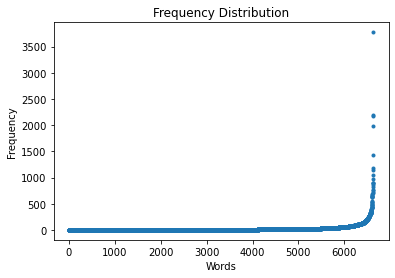

In [402]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [403]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

data 3774
patient 2185
healthcare 2180
model 1981
health 1426
system 1174
machine 1148
method 1048
based 975
study 900
care 892
result 888
clinical 849
ai 826
medical 772
big 761
risk 728
approach 714
information 677
research 673
network 649
application 646
disease 636
algorithm 632
time 621
prediction 558
analysis 541
paper 539
technology 506
performance 504


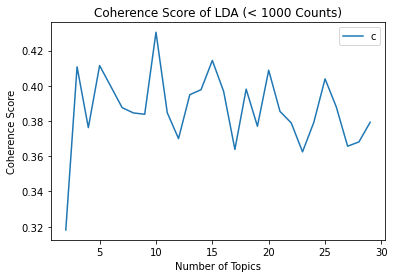

In [328]:
coherence_score(1000)

In [408]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

limit = 1000
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords_usa = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords_usa.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio_usa = []
for i in range(len(doc_term_matrix)):
    topic_ratio_usa.append(ldaModel[doc_term_matrix[i]])

In [409]:
keywords_usa

[['Topic 0',
  'clinical, medical, based, algorithm, information, approach, result, record, decision, knowledge, research, large, performance, risk, electronic'],
 ['Topic 1',
  'risk, prediction, result, hospital, study, care, network, accuracy, feature, neural, cost, performance, disease, predict, time'],
 ['Topic 2',
  'analytics, technology, ai, research, care, social, intelligence, cost, information, practice, artificial, new, paper, analysis, industry'],
 ['Topic 3',
  'ai, care, study, research, community, provider, student, technology, service, result, experience, medical, review, population, based'],
 ['Topic 4',
  'application, based, network, device, paper, human, deep, sensor, time, user, proposed, disease, framework, algorithm, approach']]

## China Topic Modeling

In [410]:
i = 0
cps_name, cps_data = [], []
for item in df_filtered[df_filtered['Country'] == 'China']['Abstract']:
    globals()['cps{}'.format(i)] = item.lower()
    cps_name.append('cps{}'.format(i))
    cps_data.append(globals()['cps{}'.format(i)])
    i += 1

In [411]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

3550


Text(0, 0.5, 'Frequency')

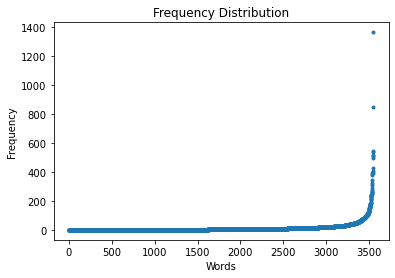

In [336]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [337]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

data 1366
healthcare 851
model 548
medical 541
system 515
method 510
based 499
patient 430
network 407
big 392
health 392
proposed 378
result 344
information 327
feature 308
paper 287
disease 277
study 265
analysis 260
application 253
service 249
performance 243
algorithm 243
deep 236
time 236
technology 226
used 225
machine 216
neural 212
accuracy 205


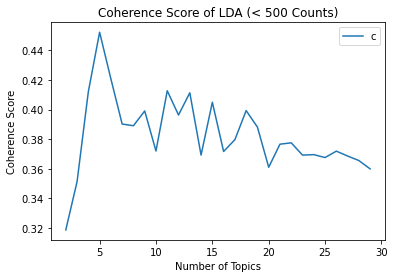

In [338]:
coherence_score(500)

In [418]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

limit = 500
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords_china = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords_china.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio_china = []
for i in range(len(doc_term_matrix)):
    topic_ratio_china.append(ldaModel[doc_term_matrix[i]])

In [419]:
keywords_china

[['Topic 0',
  'feature, classification, disease, algorithm, proposed, accuracy, machine, performance, patient, result, diagnosis, image, network, neural, prediction'],
 ['Topic 1',
  'patient, ai, health, research, analysis, study, service, china, information, development, clinical, factor, technology, disease, paper'],
 ['Topic 2',
  'patient, information, study, result, network, prediction, approach, group, disease, technology, smart, process, proposed, mortality, time'],
 ['Topic 3',
  'proposed, feature, activity, network, time, recognition, result, accuracy, performance, neural, ecg, approach, real, algorithm, deep'],
 ['Topic 4',
  'health, privacy, cloud, network, paper, service, technology, iot, application, scheme, user, security, smart, deep, proposed']]

In [420]:
data = []
for topic in keywords_china:
    temp = []
    temp += ([topic[0]] + [word.replace("'",'').replace(' ','') for word in topic[1].split(',')])
    data.append(temp)
pd.DataFrame(data).to_excel(r'C:\Users\Yunseok Choi\Google 드라이브\기술경영대학원\STEPI\healthcare_temp.xlsx')

In [425]:
keywords_china_byword = []
for topic in keywords_china:
    for words in topic:
        for word in words.split(','):
            keywords_china_byword.append(word.replace(' ',''))

In [427]:
keywords_usa_byword = []
for topic in keywords_usa:
    for words in topic:
        for word in words.split(','):
            keywords_usa_byword.append(word.replace(' ',''))

In [428]:
keywords_byword = []
for topic in keywords:
    for words in topic:
        for word in words.split(','):
            keywords_byword.append(word.replace(' ',''))

In [430]:
for word in keywords_usa_byword:
    if word not in keywords_byword:
        print(word)

medical
based
result
record
knowledge
large
electronic
result
study
predict
social
new
paper
industry
study
provider
result
medical
population
based
based
paper
human


In [429]:
for word in keywords_china_byword:
    if word not in keywords_byword:
        print(word)

machine
patient
result
diagnosis
patient
health
study
china
paper
patient
study
result
process
mortality
recognition
result
ecg
real
health
paper
scheme


## Backward Citation Setup

In [462]:
df_back = pd.read_excel(r'C:\Users\Yunseok Choi\Google 드라이브\기술경영대학원\STEPI\AI_Healthcare_backwardcitation.xlsx')
df_back.dropna(subset = ['Abstract','Publication Year'], inplace = True, axis = 0)

In [488]:
df_filtered.columns

Index(['index', 'Publication Type', 'Authors', 'Book Authors', 'Book Editors',
       'Book Group Authors', 'Author Full Names', 'Book Author Full Names',
       'Group Authors', 'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Reprint Addresses', 'Email Addresses', 'Researcher Ids',
       'ORCIDs', 'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Supplement', 'Specia

In [466]:
df_back.reset_index(inplace = True)

In [495]:
wos_usa = []
for item in usa_index:
    wos_usa.append(df_filtered.iloc[item]['UT (Unique WOS ID)'])

In [496]:
wos_china = []
for item in china_index:
    wos_china.append(df_filtered.iloc[item]['UT (Unique WOS ID)'])

In [546]:
cps_data_china, cps_data_usa = [], []
back_index_china , back_index_usa = [], []
for i in range(df_back.shape[0]):
    if df_back['CIted By'][i] in wos_china:
        cps_data_china.append(df_back['Abstract'][i].lower())
        back_index_china.append(i)
    elif df_back['CIted By'][i] in wos_usa:
        cps_data_usa.append(df_back['Abstract'][i].lower())
        back_index_usa.append(i)

In [518]:
len(cps_data_usa)

25300

In [519]:
len(cps_data_china)

9969

## Backward Citation

In [540]:
cps_data_back = []
for item in df_back['Abstract']:
    cps_data_back.append(item.lower())

In [541]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_back:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

66168


Text(0, 0.5, 'Frequency')

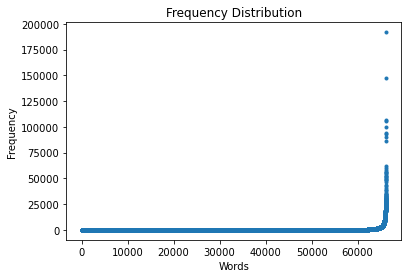

In [542]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [543]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

data 191812
patient 147684
method 106289
model 105538
study 99820
system 94060
based 93238
result 90062
health 86414
network 62254
analysis 60497
care 58231
disease 56468
time 56061
algorithm 55492
clinical 54133
paper 52262
feature 51844
risk 51482
approach 50710
information 49741
research 48523
performance 48060
proposed 46236
medical 44016
image 42787
application 40638
different 38688
classification 38502
new 36824


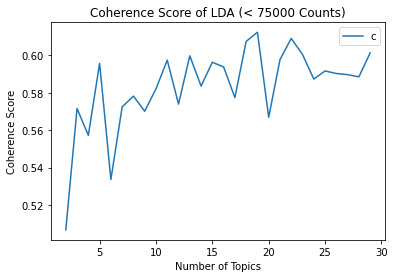

In [567]:
coherence_score(75000, passes = 5, cps_data = cps_data_back)

In [554]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 75000
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [555]:
keywords

[['Topic 0',
  'application, technology, healthcare, research, paper, user, ai, information, sensor, device, iot, challenge, network, service, new'],
 ['Topic 1',
  'algorithm, feature, network, classification, image, proposed, deep, performance, machine, accuracy, approach, neural, set, prediction, technique'],
 ['Topic 2',
  'signal, image, cell, detection, sensitivity, analysis, ecg, ct, disease, subject, brain, human, cancer, specificity, activity'],
 ['Topic 3',
  'care, clinical, review, research, intervention, covid, quality, medical, practice, social, analysis, effect, treatment, outcome, evidence'],
 ['Topic 4',
  'risk, disease, cancer, covid, hospital, age, clinical, year, mortality, outcome, score, rate, day, associated, conclusion']]

In [566]:
topic_ratio_usa = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in back_index_usa:
    for item in topic_ratio[index]:
        topic_ratio_usa[item[0]] += item[1]
for index in topic_ratio_usa.keys():
    topic_ratio_usa[index] = topic_ratio_usa[index]/len(back_index_usa)
topic_ratio_usa

{0: 0.18257322300564158,
 1: 0.22816412332670197,
 2: 0.13315925372359547,
 3: 0.24408236625254626,
 4: 0.20691300615060912,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [565]:
topic_ratio_china = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in back_index_china:
    for item in topic_ratio[index]:
        topic_ratio_china[item[0]] += item[1]
for index in topic_ratio_china.keys():
    topic_ratio_china[index] = topic_ratio_china[index]/len(back_index_china)
topic_ratio_china

{0: 0.2910486400647397,
 1: 0.30703552342855633,
 2: 0.15762504578794775,
 3: 0.12871372990849422,
 4: 0.10996377768778062,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

## USA Backward Citation

In [570]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_usa:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

28315


Text(0, 0.5, 'Frequency')

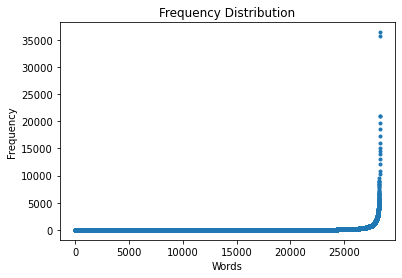

In [571]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [569]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

project 191812
healthier 147684
effective 106289
large 105538
community 99820
constitutes 94060
build 93238
care 90062
bronchial 86414
country 62254
along 60497
outcome 58231
ireland 56468
division 56061
sex 55492
average 54133
suggested 52262
reveals 51844
nevertheless 51482
prick 50710
availability 49741
people 48523
fast 48060
circumstance 46236
dimension 44016
sensitivity 42787
knime 40638
account 38688
varied 38502
provide 36824


In [529]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_usa:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 10000
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [531]:
keywords

[['Topic 0',
  'treatment, group, cost, population, year, among, outcome, intervention, rate, age, associated, woman, cancer, factor, conclusion'],
 ['Topic 1',
  'gene, cell, drug, control, cancer, brain, effect, expression, covid, tissue, response, pd, human, genetic, may'],
 ['Topic 2',
  'hospital, score, outcome, mortality, day, conclusion, readmission, rate, prediction, surgery, predictive, sensitivity, diagnosis, compared, cohort'],
 ['Topic 3',
  'research, information, medical, healthcare, review, technology, application, decision, challenge, user, paper, approach, practice, new, article'],
 ['Topic 4',
  'network, algorithm, feature, image, performance, machine, classification, deep, approach, proposed, accuracy, set, show, paper, neural']]

## China Backward Citation

In [532]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_china:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

18348


Text(0, 0.5, 'Frequency')

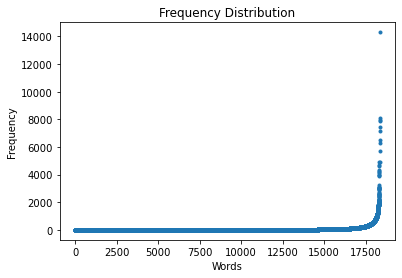

In [533]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [534]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

data 14299
method 8123
patient 7974
model 7870
based 7471
system 7176
result 6498
network 6323
study 5687
feature 4917
health 4900
proposed 4691
paper 4623
time 4346
algorithm 4252
analysis 4165
information 4142
disease 4000
performance 3999
approach 3917
application 3242
classification 3117
medical 3091
risk 3069
user 3048
image 3014
different 2963
research 2939
clinical 2931
problem 2918


In [535]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_china:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 5000
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [536]:
keywords

[['Topic 0',
  'health, research, care, medical, information, quality, healthcare, review, analysis, service, social, record, clinical, technology, user'],
 ['Topic 1',
  'feature, algorithm, classification, image, proposed, performance, approach, deep, neural, accuracy, machine, set, paper, recognition, problem'],
 ['Topic 2',
  'disease, risk, cancer, treatment, clinical, year, diabetes, age, mortality, group, associated, conclusion, factor, rate, among'],
 ['Topic 3',
  'application, user, cloud, paper, sensor, time, device, proposed, scheme, mobile, security, privacy, service, activity, smart'],
 ['Topic 4',
  'signal, sensor, activity, ecg, time, subject, detection, analysis, measurement, heart, motion, pressure, eeg, rate, gait']]